## PyCuda Code for two-dimensional phase-field model for conserved order parameter (Cahn-Hilliard equation) 

### import libraries

In [ ]:
%matplotlib nbagg
import numpy as np 
import matplotlib.pyplot as plt

!pip install pycuda # install pycuda
import pycuda.driver as drv
from pycuda.compiler import SourceModule

### set parameters and physical values

In [ ]:
nx, ny = 32, 32 # number of computational grids along x direction
dx, dy = 2.0e-9, 2.0e-9 # spacing of computational grids [m]
c0 = 0.5 # average composition of B atom [atomic fraction]
R = 8.314 # gas constant
temp = 673 # temperature [K]
La = 20000.-9.*temp # Atom intaraction constant [J/mol]
ac = 3.0e-14 # gradient coefficient [Jm2/mol]
Da = 1.0e-04*np.exp(-300000.0/R/temp) # diffusion coefficient of A atom [m2/s]
Db = 2.0e-05*np.exp(-300000.0/R/temp) # diffusion coefficient of B atom [m2/s]
dt = (dx*dx/Da)*0.1 # time increment [s]

### draw chemical free energy density curve

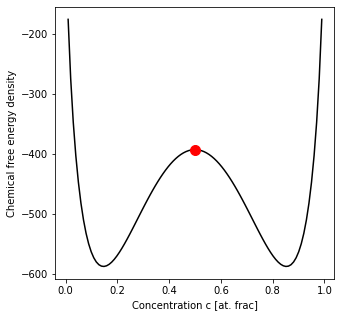

In [ ]:
fig = plt.figure(figsize=(5,5))
cc = np.linspace(0.01, 0.99, 100);
plt.plot(cc, R*temp*(cc*np.log(cc)+(1-cc)*np.log(1-cc))+La*cc*(1-cc),color='black')
plt.plot(c0, R*temp*(c0*np.log(c0)+(1-c0)*np.log(1-c0))+La*c0*(1-c0),color='r',marker='o',markersize=10)
plt.xlabel('Concentration c [at. frac]')
plt.ylabel('Chemical free energy density')
plt.show()

### declair arrays for the order parameters $c$ at time $t$ and $t+\Delta t$ on Host (CPU) memory

In [ ]:
c = np.zeros((nx,ny)).astype(np.float32) # order parameter c at time t
c_new = np.zeros((nx,ny)).astype(np.float32) # order parameter c at time t+dt

### define the kernel which is calculated on GPU

In [1]:
# CUDA Cで記述する
def get_kernel_string(nx, ny, dx, dy, R, temp, La, ac, Da, Db, mob, dt):
    return """
    #define nx %d
    #define ny %d
    #define dx %f
    #define dy %f
    #define R %f
    #define temp %f
    #define La %f
    #define ac %f
    #define Da %f
    #define Db %f
    #define mob %f
    #define dt %f
    __gloval__ void kernel(float *u_new, float *u){

        int i = blockIdx.x * block_size_x + threadIdx.x;
        int j = blockIdx.y * block_size_y + threadIdx.y;

        int ip = i + 1;
        int im = i - 1;
        int jp = j + 1;
        int jm = j - 1;
        int ipp = i + 2;
        int imm = i - 2;
        int jpp = j + 2;
        int jmm = j - 2;

        if(ip > nx-1) {ip = ip - nx;}
        if(im < 0    ) {im = im + nx;}
        if(jp > ny-1) {jp = jp - ny;}
        if(jm < 0    ) {jm = jm + ny;}
        if(ipp > nx-1) {ipp = ipp - nx;}
        if(imm < 0 ) {imm = imm + nx;}
        if(if jpp > ny-1) {jpp = jpp - ny;}
        if(jmm < 0 ) {jmm = jmm + ny;}
            
        float cc = u[j*nx+i];
        float ce = u[j*nx+ip];
        float cw = u[j*nx+im];
        float cs = u[jm*nx+i];
        float cn = u[jp*nx+i];
        float cse = u[jm*nx+ip];
        float cne = u[jp*nx+ip];
        float csw = u[jm*nx+im];
        float cnw = u[jp*nx+im];
        float cee = u[j*nx+ipp];
        float cww = u[j*nx+imm];
        float css = u[jmm*nx+i];
        float cnn = u[jpp*nx+i];
        
        # chemical term of the diffusion potential
        float mu_chem_c = R*temp*(log(cc)-log(1.0-cc)) + La*(1.0-2.0*cc); 
        float mu_chem_w = R*temp*(log(cw)-log(1.0-cw)) + La*(1.0-2.0*cw); 
        float mu_chem_e = R*temp*(log(ce)-log(1.0-ce)) + La*(1.0-2.0*ce); 
        float mu_chem_n = R*temp*(log(cn)-log(1.0-cn)) + La*(1.0-2.0*cn);  
        float mu_chem_s = R*temp*(log(cs)-log(1.0-cs)) + La*(1.0-2.0*cs); 

        # gradient term of the diffusion potential
        float mu_grad_c = -ac*( (ce -2.0*cc +cw )/dx/dx + (cn  -2.0*cc +cs )/dy/dy); 
        float mu_grad_w = -ac*( (cc -2.0*cw +cww)/dx/dx + (cnw -2.0*cw +csw)/dy/dy);
        float mu_grad_e = -ac*( (cee-2.0*ce +cc )/dx/dx + (cne -2.0*ce +cse)/dy/dy); 
        float mu_grad_n = -ac*( (cne-2.0*cn +cnw)/dx/dx + (cnn -2.0*cn +cc )/dy/dy); 
        float mu_grad_s = -ac*( (cse-2.0*cs +csw)/dx/dx + (cc  -2.0*cs +css)/dy/dy);              
        
        # total diffusion potental
        float mu_c = mu_chem_c + mu_grad_c; 
        float mu_w = mu_chem_w + mu_grad_w; 
        float mu_e = mu_chem_e + mu_grad_e; 
        float mu_n = mu_chem_n + mu_grad_n; 
        float mu_s = mu_chem_s + mu_grad_s; 
    
        float nabla_mu = (mu_w -2.0*mu_c + mu_e)/dx/dx + (mu_n -2.0*mu_c + mu_s)/dy/dy;    
        float dc2dx2 = ((ce-cw)*(mu_e-mu_w))/(4.0*dx*dx);
        float dc2dy2 = ((cn-cs)*(mu_n-mu_s))/(4.0*dy*dy); 
            
        float DbDa = Db/Da;
        float mob = (Da/R/temp)*(cc+DbDa*(1.0-cc))*cc*(1.0-cc); 
        float dmdc = (Da/R/temp)*((1.0-DbDa)*cc*(1.0-cc)+(cc+DbDa*(1.0-cc))*(1.0-2.0*cc)); 
        
        # right-hand side of Cahn-Hilliard equation
        float dcdt = mob*nabla_mu + dmdc*(dc2dx2 + dc2dy2); 
        
        # update order parameter c 
        u_new[j*nx+i] = u[j*nx+i] + dcdt*dt; 
    }
    """ % (nx, ny, dx, dy, R, temp, La, ac, Da, Db, mob, dt)

kernel_string = get_kernel_string(nx, ny, dx, dy, R, temp, La, ac, Da, Db, mob, dt)

NameError: name 'nx' is not defined

### set initial distribution of order paraemter (concentration of B atom)

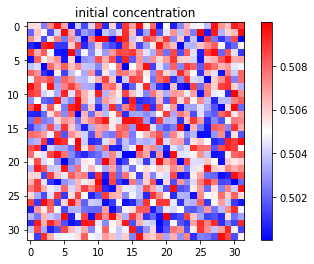

In [ ]:
c = c0 + np.random.rand(nx, ny)*0.01

plt.imshow(c, cmap='bwr')
plt.title('initial concentration')
plt.colorbar()
plt.show()

### solve Cahn-Hilliard equation using GPU

nstep =  600
Maximum concentration =  0.5117215145962422
Minimum concentration =  0.49837468303008825


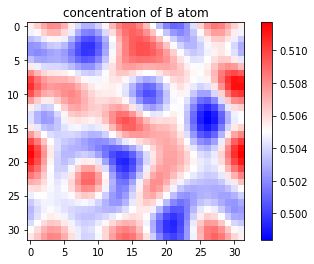

nstep =  1200
Maximum concentration =  0.5343056090199151
Minimum concentration =  0.4789393499066896


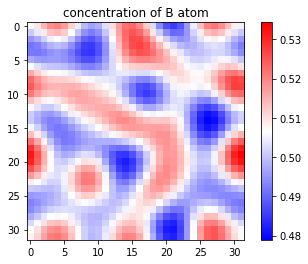

nstep =  1800
Maximum concentration =  0.6350393655324117
Minimum concentration =  0.40314179121926824


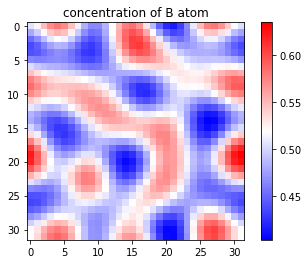

nstep =  2400
Maximum concentration =  0.8033145057292603
Minimum concentration =  0.24362615316419245


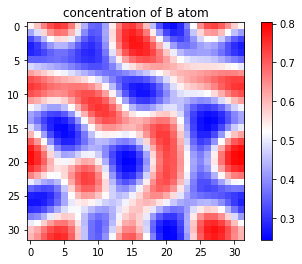

nstep =  3000
Maximum concentration =  0.8410121411792085
Minimum concentration =  0.17746324785665374


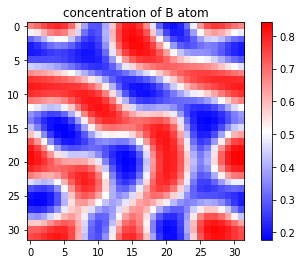

nstep =  3600
Maximum concentration =  0.8396400252495221
Minimum concentration =  0.17146104510281868


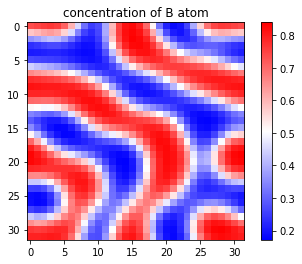

nstep =  4200
Maximum concentration =  0.8368535910147752
Minimum concentration =  0.16606344952391408


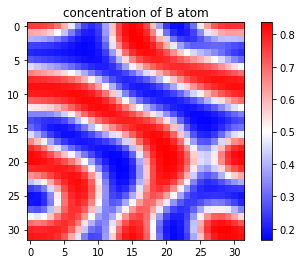

nstep =  4800
Maximum concentration =  0.8390543734590815
Minimum concentration =  0.16073617854994873


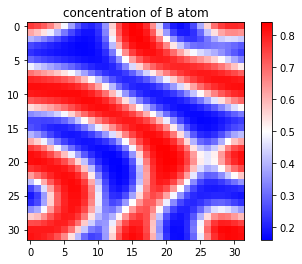

nstep =  5400
Maximum concentration =  0.8411734875435702
Minimum concentration =  0.15841723509851305


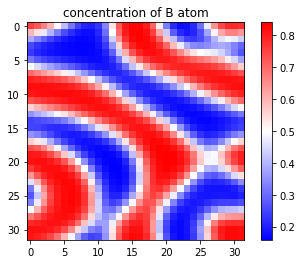

nstep =  6000
Maximum concentration =  0.8430583863397331
Minimum concentration =  0.15518674983311562


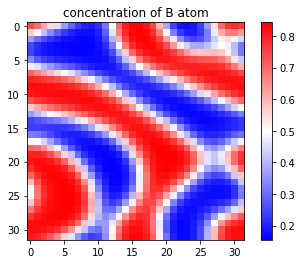

In [ ]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#allocate GPU memory
u_old = drv.mem_alloc(c.nbytes)
u_new = drv.mem_alloc(c_new.nbytes)

#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)

block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"
execute_kernel = SourceModule(block_size_string+kernel_string, arch='sm_'+cc).get_function("kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data from the Host (CPU) memory to the Device (GPU) memory
drv.memcpy_htod(u_old, c)
drv.memcpy_htod(u_new, c)

#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(500):
    execute_kernel(u_new, u_old, block=threads, grid=grid)
    execute_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print("1000 steps of execution took", end.time_since(start), "ms.")

#copy the result data from the Device (GPU) to the Host (CPU) for plotting
gpu_result = np.zeros_like(c)
drv.memcpy_dtoh(gpu_result, u_new)
    
print('Maximum concentration = ', np.max(c))
print('Minimum concentration = ', np.min(c))
plt.imshow(gpu_result, cmap='bwr')
plt.title('concentration of B atom')
plt.colorbar()
plt.show() 